In [58]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import operator
import statistics
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [59]:
#load users raw data
interactions = pd.read_csv(r"C:\Users\salma.katri\Desktop\Metis\NLP\data\RAW_interactions.csv")

In [60]:
#load recipes raw data
recipes = pd.read_csv(r"C:\Users\salma.katri\Desktop\Metis\NLP\data\RAW_recipes.csv")

## Data Exploration

In [61]:
interactions.shape

(1132367, 5)

In [62]:
interactions.rating.unique()

array([4, 5, 0, 2, 3, 1], dtype=int64)

In [63]:
# number of users
len(interactions['user_id'].unique())

226570

In [64]:
# number of unique recipes
len(interactions['recipe_id'].unique())

231637

In [65]:
# avg number of recipes rated per user
ratings_per_user = interactions.groupby('user_id')['rating'].count()
statistics.mean(ratings_per_user.tolist())

4.997868208500684

In [66]:
ratings_per_user.sort_values(ascending=False)

user_id
424680     7671
37449      5603
383346     4628
169430     4076
128473     3917
           ... 
2744231       1
2744177       1
2744161       1
2744132       1
1579230       1
Name: rating, Length: 226570, dtype: int64

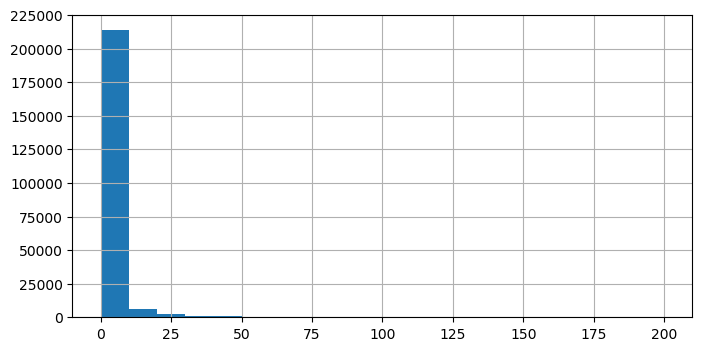

In [67]:
# distribution of ratings per user
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 4), dpi=100)
ratings_per_user.hist(bins=20, range=(0,200))

In [68]:
# avg number of ratings given per recipe
ratings_per_recipe = interactions.groupby('recipe_id')['rating'].count()
statistics.mean(ratings_per_recipe.tolist())

4.888541122532238

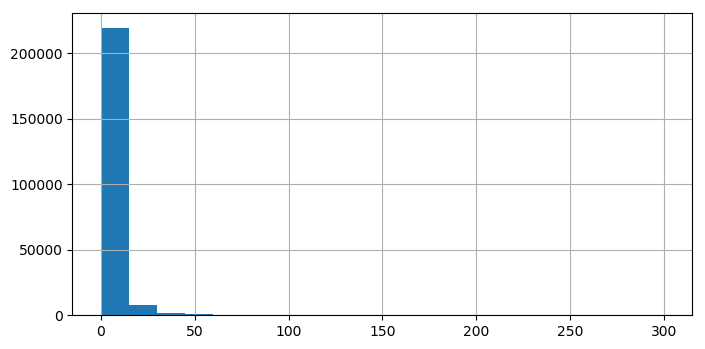

In [69]:
# distribution of ratings per recipe
figure(figsize=(8, 4), dpi=100)
ratings_per_recipe.hist(bins=20, range=(0,300))

## Data Manipulation

In [70]:
# counts of ratings per recipe as a df
ratings_per_recipe_df = pd.DataFrame(ratings_per_recipe)
# remove if < 50 ratings
filtered_ratings_per_recipe_df = ratings_per_recipe_df[ratings_per_recipe_df.rating >= 50]
# build a list of recipe_ids to keep
popular_recipes = filtered_ratings_per_recipe_df.index.tolist()

In [71]:
# counts ratings per user as a df
ratings_per_user_df = pd.DataFrame(ratings_per_user)
# remove if < 50
filtered_ratings_per_user_df = ratings_per_user_df[ratings_per_user_df.rating >= 50]
# build a list of user_ids to keep
prolific_users = filtered_ratings_per_user_df.index.tolist()

In [72]:
#only keep popular recipes and prolific users
filtered_ratings = interactions[interactions.recipe_id.isin(popular_recipes)]
filtered_ratings = interactions[interactions.user_id.isin(prolific_users)]
filtered_ratings.shape

(606866, 5)

## Recommender System

In [73]:
#create user-rating matrix
rating_matrix = filtered_ratings.pivot_table(index='user_id', columns='recipe_id', values='rating')
# replace NaN values with 0
rating_matrix = rating_matrix.fillna(0)
rating_matrix.head()

recipe_id,38,40,41,45,46,49,52,53,55,58,...,536734,536990,537071,537073,537175,537241,537319,537458,537459,537485
user_id,,,,,,,,,,,,,,,,,,,,,
1533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
#create function to find similar users
def similar_users(user_id, matrix, k=3):
    # create a df of just the current user
    user = matrix[matrix.index == user_id]
    
    # and a df of all other users
    other_users = matrix[matrix.index != user_id]
    
    # calc cosine similarity between user and each other user
    similarities = cosine_similarity(user,other_users)[0].tolist()
    
    # create list of indices of these users
    indices = other_users.index.tolist()
    
    # create key/values pairs of user index and their similarity
    index_similarity = dict(zip(indices, similarities))
    
    # sort by similarity
    index_similarity_sorted = sorted(index_similarity.items(), key=operator.itemgetter(1))
    index_similarity_sorted.reverse()
    
    # grab k users off the top
    top_users_similarities = index_similarity_sorted[:k]
    users = [u[0] for u in top_users_similarities]
    
    return users
    
current_user = 1533
similar_user_indices = similar_users(current_user, rating_matrix)
print(similar_user_indices)

[103809, 28339, 29212]


In [75]:
def recommend_item(user_index, similar_user_indices, matrix, items=5):
    
    # load vectors for similar users
    similar_users = matrix[matrix.index.isin(similar_user_indices)]
    # calc avg ratings across the 3 similar users
    similar_users = similar_users.mean(axis=0)
    # convert to dataframe so its easy to sort and filter
    similar_users_df = pd.DataFrame(similar_users, columns=['mean'])
    
    
    # load vector for the current user
    user_df = matrix[matrix.index == user_index]
    # transpose it so its easier to filter
    user_df_transposed = user_df.transpose()
    # rename the column as 'rating'
    user_df_transposed.columns = ['rating']
    # remove any rows without a 0 value (recipes not rated yet)
    user_df_transposed = user_df_transposed[user_df_transposed['rating']==0]
    # generate a list of recipes the user has not rated
    recipes_unrated = user_df_transposed.index.tolist()
    
    # filter avg ratings of similar users for only recipes the current user has not rated
    similar_users_df_filtered = similar_users_df[similar_users_df.index.isin(recipes_unrated)]
    # order the dataframe
    similar_users_df_ordered = similar_users_df.sort_values(by=['mean'], ascending=False)
    # grab the top n recipes   
    top_n_recipes = similar_users_df_ordered.head(items)
    top_n_recipes_indices = top_n_recipes.index.tolist()
    # lookup these recipes in the other dataframe to find names
    recipes_information = recipes[recipes['id'].isin(top_n_recipes_indices)]
    
    return recipes_information #items
# try it out
recommend_item(1533, similar_user_indices, rating_matrix)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
43029,chicken and stuffing bake,37423,40,22015,2002-08-16,"['60-minutes-or-less', 'time-to-make', 'course...","[251.3, 7.0, 11.0, 24.0, 58.0, 6.0, 7.0]",10,"['preheat oven to 400 degrees', 'prepare stuff...",a long time favorite that i just found again.,"['chicken flavor stuffing mix', 'boneless skin...",5
78674,easy creamy hamburger stroganoff,36784,15,36128,2002-08-12,"['15-minutes-or-less', 'time-to-make', 'course...","[417.6, 45.0, 17.0, 27.0, 53.0, 64.0, 3.0]",4,['brown hamburger in large skillet with onion ...,this easy version of stroganoff is so deliciou...,"['hamburger', 'onion', 'garlic clove', 'cream ...",9
163319,pork chops yum yum,95222,70,82507,2004-07-07,"['time-to-make', 'course', 'main-ingredient', ...","[427.1, 27.0, 78.0, 53.0, 87.0, 30.0, 6.0]",4,"['brown chops on both sides', 'place in grease...",i copied this from the orlando sentinel months...,"['pork chops', 'chicken broth', 'honey', 'soy ...",7
187399,simple tomato sandwich,98724,5,81611,2004-08-27,"['15-minutes-or-less', 'time-to-make', 'course...","[266.0, 16.0, 40.0, 27.0, 10.0, 8.0, 12.0]",6,"['toast bread', 'slice tomato', 'when bread is...",i am only posting such a simple recipe because...,"['bread', 'tomatoes', 'miracle whip', 'salt']",4
219891,uncle bill s whipped shortbread cookies,46877,32,27416,2002-11-19,"['60-minutes-or-less', 'time-to-make', 'course...","[110.8, 11.0, 14.0, 2.0, 1.0, 24.0, 3.0]",13,"['preheat oven to 350 degrees f', 'in a mixing...",these are very easy to make shortbread cookies...,"['butter', 'all-purpose flour', 'icing sugar',...",6
